In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Download required libraries and dependencies

In [ ]:
!pip install pytorch_transformers
!pip install transformers 

from Model import Model

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from torch.optim import SGD, Adam
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import random
import re
import string
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output            #remove all unnecessary conclusions. If there are mistakes, then everything will stop earlier
clear_output()

import warnings
warnings.filterwarnings("ignore")

SEED = 42

# Load prepared data and work with it

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dataset/AMAZON_FASHION.csv')
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
883631,5.0,True,"02 21, 2017",A1ZSB2Q144UTEY,B01HJHTH5U,Amazon Customer,I absolutely love this dress!! It's sexy and ...,I absolutely love this dress,1487635200,NaN,NaN,NaN
883632,5.0,True,"11 25, 2016",A2CCDV0J5VB6F2,B01HJHTH5U,Amazon Customer,I'm 5'6 175lbs. I'm on the tall side. I wear a...,I wear a large and ordered a large and it stil...,1480032000,2.0,NaN,NaN
883633,3.0,True,"11 10, 2016",A3O90PACS7B61K,B01HJHTH5U,Fabfifty,Too big in the chest area!,Three Stars,1478736000,NaN,NaN,NaN
883634,3.0,True,"11 10, 2016",A2HO94I89U3LNH,B01HJHF97K,Mgomez,"Too clear in the back, needs lining",Three Stars,1478736000,NaN,NaN,NaN


Convert <code>overall</code> to <code>sentiment</code> for classification

In [ ]:
data = df[['overall', 'reviewText', 'summary']]
data['sentiment'] = data.overall.map(lambda x: 1 if x > 3 else 0)
data

,overall,reviewText,summary,sentiment
0,5.0,Exactly what I needed.,perfect replacements!!,1
1,2.0,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",0
2,4.0,Love these... I am going to order another pack...,My New 'Friends' !!,1
3,2.0,too tiny an opening,Two Stars,0
4,3.0,Okay,Three Stars,0
...,...,...,...,...
883631,5.0,I absolutely love this dress!! It's sexy and ...,I absolutely love this dress,1
883632,5.0,I'm 5'6 175lbs. I'm on the tall side. I wear a...,I wear a large and ordered a large and it stil...,1
883633,3.0,Too big in the chest area!,Three Stars,0
883634,3.0,"Too clear in the back, needs lining",Three Stars,0


Display the distribution of our data

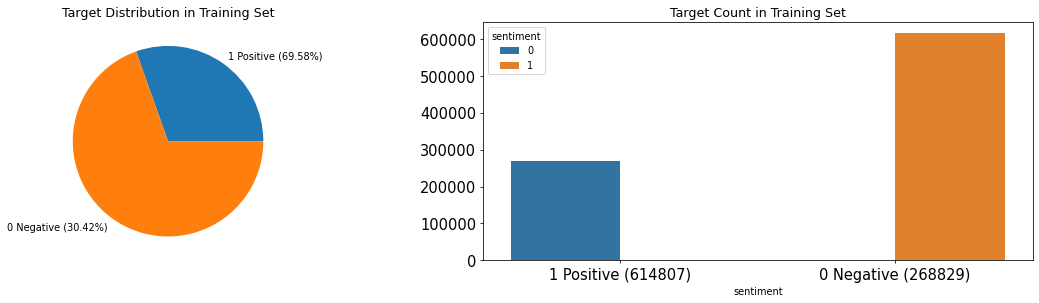

In [ ]:
def plot_label_distribution(data):
    percentage = data.groupby('sentiment').size() / len(data) * 100
    amount = data.groupby('sentiment').size()

    fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=70)
    plt.tight_layout()

    data.groupby('sentiment').count()['reviewText'].plot(kind='pie', ax=axes[0], labels=['1 Positive ({0:.2f}%)'.format(percentage[1]), '0 Negative ({0:.2f}%)'.format(percentage[0])])
    sns.countplot(x=data['sentiment'], hue=data['sentiment'], ax=axes[1])

    axes[0].set_ylabel('')
    axes[1].set_ylabel('')
    axes[1].set_xticklabels(['1 Positive ({})'.format(amount[1]), '0 Negative ({})'.format(amount[0])])
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)

    axes[0].set_title('Target Distribution in Training Set', fontsize=13)
    axes[1].set_title('Target Count in Training Set', fontsize=13)

    plt.show()

plot_label_distribution(data)

Remove lines with bad <code>summary</code>

In [ ]:
data = data.dropna()
data.summary = data.summary.map(lambda x: x.lower())
data = data[~data['summary'].str.contains("star")]
data = data[data.reviewText.map(lambda x: len(x) < 512)]

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
data = data.sample(5000)

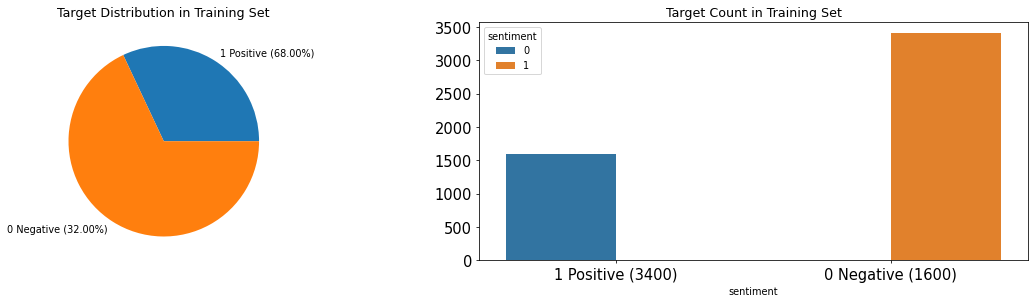

In [ ]:
plot_label_distribution(data)

In [ ]:
for i in range(10):
    try:
        print('text: ', data.reviewText[i])
        print('review: ', data.summary[i])
        print('------------------')
    except:
        pass

Распределение осталось тем же

## Data processing

In [ ]:
sentences = data.reviewText

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]  
labels = []

for item in data['sentiment']:
  labels.append([item])

In [ ]:
for i in range(10):
    key = random.randint(0, 1000)
    print(data.reviewText.iloc[key])
    print(sentences[key])
    print(labels[key])
    print('')

This umbrella is adorable, easy to operate, and seems relatively safe with no sharp corners or edges. When it arrived, it had some fine white powder on it, which was easily wiped away with a damp cloth. It arrives in a large brown amazon box...it does not have its own brand/packaging.
[CLS] This umbrella is adorable, easy to operate, and seems relatively safe with no sharp corners or edges. When it arrived, it had some fine white powder on it, which was easily wiped away with a damp cloth. It arrives in a large brown amazon box...it does not have its own brand/packaging. [SEP]
[1]

It is just adorable. Very nice. The material has a rich look.  It has scripture references on each corner. And comes with a carrying bag. I love it.
[CLS] It is just adorable. Very nice. The material has a rich look.  It has scripture references on each corner. And comes with a carrying bag. I love it. [SEP]
[1]

Three of the pairs we received were briefs, as advertised, but the other three were hipsters. I 

Make train test split

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.5, random_state=SEED, stratify=data['sentiment'])

Download tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") 
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

100%|██████████| 231508/231508 [00:00<00:00, 317050.16B/s]


In [ ]:
print (train_sentences[1], '\n')
print (tokenized_texts[1])
print (labels[1])

[CLS] Beautiful bracelet! Swarovski never disappoints! [SEP] 

['[CLS]', 'beautiful', 'bracelet', '!', 'sw', '##aro', '##vs', '##ki', 'never', 'di', '##sa', '##pp', '##oint', '##s', '!', '[SEP]']
[0]


Split our sample into training and validation

In [ ]:
maxlen = pd.Series(tokenized_texts).map(lambda x: len(x)).quantile(1)
maxlen = int(maxlen)
print(maxlen)

195


In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,                              #tokens
    maxlen= maxlen,                         #max tokens
    dtype="long",
    truncating="post",                      #cut after
    padding="post"                          #padding right
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=SEED,
    test_size=0.2,
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=SEED,
    test_size=0.2,
)


Convert our data to batches

In [ ]:
train_inputs = torch.LongTensor(train_inputs)
train_labels = torch.LongTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.LongTensor(validation_inputs)
validation_labels = torch.LongTensor(validation_labels)
validation_masks = torch.LongTensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=25
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    shuffle=True,
    batch_size=25
)

Download the pretrained model

In [ ]:
# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

model = torch.load('/content/drive/My Drive/Dataset/model_1.pth')

In [ ]:
# # D_in - input dimension (768 у BERT);
# # H - dimension of hidden layers; 
# # D_out - the dimension of the output layer (the number of classes)
# D_in, H, D_out = 768, 2000, 2

# # Use the nn package to define our model and loss function.
# classifier = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.PReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.Dropout(0.1),
#     torch.nn.PReLU(),
#     torch.nn.Linear(H, D_out),
# )

# model.classifier = classifier

model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

If we want to freez some layers

In [ ]:
# layers_to_unfreeze = 4 + 16 * 5

params = list(model.named_parameters())
# for p in params[:-layers_to_unfreeze]:    
#     p[1].requires_grad = False

for p in params[:]:    
    print("{:<55} {:>12}".format(p[0], str(p[1].requires_grad)))

bert.embeddings.word_embeddings.weight                          True
bert.embeddings.position_embeddings.weight                      True
bert.embeddings.token_type_embeddings.weight                    True
bert.embeddings.LayerNorm.weight                                True
bert.embeddings.LayerNorm.bias                                  True
bert.encoder.layer.0.attention.self.query.weight                True
bert.encoder.layer.0.attention.self.query.bias                  True
bert.encoder.layer.0.attention.self.key.weight                  True
bert.encoder.layer.0.attention.self.key.bias                    True
bert.encoder.layer.0.attention.self.value.weight                True
bert.encoder.layer.0.attention.self.value.bias                  True
bert.encoder.layer.0.attention.output.dense.weight              True
bert.encoder.layer.0.attention.output.dense.bias                True
bert.encoder.layer.0.attention.output.LayerNorm.weight          True
bert.encoder.layer.0.attention.out

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                )


epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Construct helper class for our model

In [ ]:
Model = Model(model, optimizer, scheduler)

Traning

In [ ]:
Model.fit(train_dataloader, validation_dataloader, epochs=epochs)


  Average training loss: 0.23
  Training epoch took: 0:02:10

Running Validation...


  Accuracy: 0.91
  Validation Loss: 0.25
  Validation took: 0:00:12



  Average training loss: 0.17
  Training epoch took: 0:02:11

Running Validation...


  Accuracy: 0.91
  Validation Loss: 0.26
  Validation took: 0:00:12

Training complete!
Total training took 0:04:45 (h:mm:ss)


Let's see the training and validation statistics

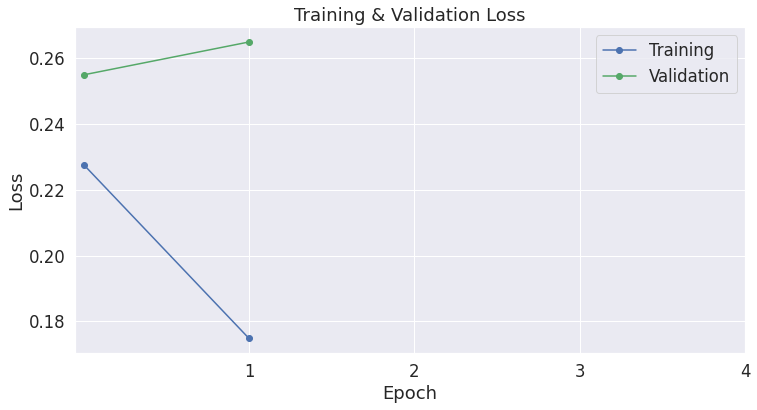

,Training Loss,Valid. Loss,Valid. Accuracy,Training Time,Validation Time,Best Model
epoch,,,,,,
1,0.23,0.25,0.91,0:02:10,0:00:12,True
2,0.17,0.26,0.91,0:02:11,0:00:12,False


In [ ]:
Model.show_training_stats()

#Оценка качества на отложенной выборке

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=maxlen,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids).to(torch.int64)
prediction_masks = torch.tensor(attention_masks).to(torch.int64)
prediction_labels = torch.tensor(test_gt).to(torch.int64)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=64
)

In [ ]:
test_preds, test_labels = Model.predict(prediction_dataloader)

In [ ]:
print("Metrics on test sample")

print("Accuracy: {0:.4f}".format(
    accuracy_score(test_labels, test_preds)
))

print("Precision: {0:.4f}".format(
    precision_score(test_labels, test_preds, average='macro')
))

print("Recall {0:.4f}".format(
    recall_score(test_labels, test_preds, average='macro')
))

print("F1 score: {0:.4f}".format(
    f1_score(test_labels, test_preds, average='macro')
))

Метрики качества на отложенной выборке
Accuracy: 0.9116
Precision: 0.8996
Recall 0.8966
F1 score: 0.8981


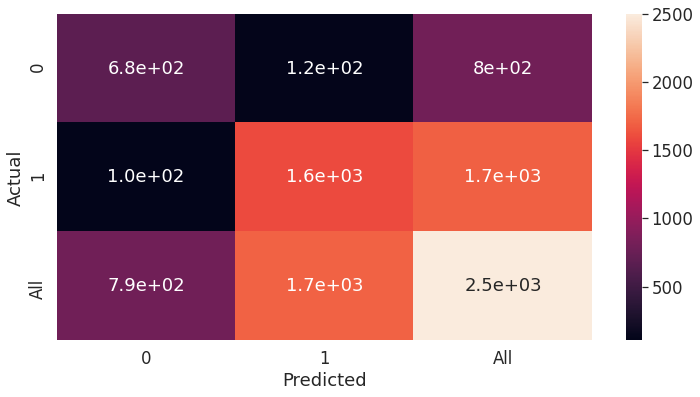

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

data = {'y_Actual':    test_labels,
        'y_Predicted': test_preds
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)


In [ ]:
# torch.save(model, '/content/drive/My Drive/Dataset/model_1.pth')